<h1>Import Nescessary Library</h1>

In [12]:
import pandas as pd
import numpy as np
import contractions
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

<h1>Preprocess (Cleanse Data)</h1>

In [2]:
# Import Data
df = pd.read_csv("Dataset/Sentiment_Stock_data.csv", usecols=["Sentiment", "Sentence"])
df = df.head(10000)
# print(df.to_string)


In [3]:
df.groupby(df["Sentiment"])["Sentiment"].count() 
df.to_string

<bound method DataFrame.to_string of       Sentiment                                           Sentence
0             0  According to Gran , the company has no plans t...
1             1  For the last quarter of 2010 , Componenta 's n...
2             1  In the third quarter of 2010 , net sales incre...
3             1  Operating profit rose to EUR 13.1 mn from EUR ...
4             1  Operating profit totalled EUR 21.1 mn , up fro...
...         ...                                                ...
9995          0  Cracks are beginning to appear in the glass ce...
9996          0                                Pay now, save later
9997          0                               Confident of success
9998          0                             Home in on big rewards
9999          0              Retailers move onwards - and upwards?

[10000 rows x 2 columns]>

In [4]:
def preprocess_text(text):
    # Check if text is a byte string, and decode if necessary
    if isinstance(text, bytes):
        text = text.decode('utf-8')  # Decode byte string to regular string

    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Convert to lowercase
    text = text.lower()

    text = re.sub('[^a-zA-Z]', ' ', text)

    # Return cleaned sentence
    return text

Deal With Null Data

In [5]:
# Drop Null value rows
df = df.dropna()

# Check Null
print(df.isnull().sum())
print(df.to_string)

Sentiment    0
Sentence     0
dtype: int64
<bound method DataFrame.to_string of       Sentiment                                           Sentence
0             0  According to Gran , the company has no plans t...
1             1  For the last quarter of 2010 , Componenta 's n...
2             1  In the third quarter of 2010 , net sales incre...
3             1  Operating profit rose to EUR 13.1 mn from EUR ...
4             1  Operating profit totalled EUR 21.1 mn , up fro...
...         ...                                                ...
9995          0  Cracks are beginning to appear in the glass ce...
9996          0                                Pay now, save later
9997          0                               Confident of success
9998          0                             Home in on big rewards
9999          0              Retailers move onwards - and upwards?

[10000 rows x 2 columns]>


Deal with Error Format Data

In [6]:
special_char= r'[a-zA-Z0-9]+(?:\s+[a-zA-Z0-9]+)*'

# Find rows where "Sentence" contains special characters
special_char_row = df[~df["Sentence"].str.contains(special_char, regex=True)].index
# print(len(special_char_row))

error_encode = "+ñ"
# Find rows where "Sentence" contains special characters
error_encode_row = df[df["Sentence"].str.contains(error_encode, regex=False)].index
# print(len(error_encode_row))

# Drop error encoded rows
# Drop special character rows
df.drop(special_char_row, axis=0, inplace=True)
df.drop(error_encode_row, axis=0, inplace=True)

df.to_string

<bound method DataFrame.to_string of       Sentiment                                           Sentence
0             0  According to Gran , the company has no plans t...
1             1  For the last quarter of 2010 , Componenta 's n...
2             1  In the third quarter of 2010 , net sales incre...
3             1  Operating profit rose to EUR 13.1 mn from EUR ...
4             1  Operating profit totalled EUR 21.1 mn , up fro...
...         ...                                                ...
9995          0  Cracks are beginning to appear in the glass ce...
9996          0                                Pay now, save later
9997          0                               Confident of success
9998          0                             Home in on big rewards
9999          0              Retailers move onwards - and upwards?

[9926 rows x 2 columns]>

In [7]:
df.reset_index(inplace=True)
df.drop(columns=["index"], inplace=True)
df["Sentence"] = df["Sentence"].apply(preprocess_text)


<h1>Text Tokenization & Padding</h1>

In [8]:
# Hyper Parameter
vocab = 10000
embed_dim = 100
input_length = 100
optimizer = Adam(0.001)

In [9]:
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(df["Sentence"])

# Convert sentences to sequences of token ex. [340, 2, 14467, 1, 72, 15, 48, 220, 2, 352, 62, 702, 2, 73, 6316, 14, 9, 281, 1, 72, 9, 683]
tokenized = tokenizer.texts_to_sequences(df["Sentence"])

# Padding Sentence to same length
X = pad_sequences(tokenizer.texts_to_sequences(df["Sentence"]), maxlen=input_length, padding="pre")

# Change to numpy array for training
y = np.array(df["Sentiment"], dtype=np.int32)

In [10]:
# Load Pretrained GloVe Embeddings
glove_path = "glove.6B/glove.6B.100d.txt"
embedding_index = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab, embed_dim))
word_index = tokenizer.word_index

# Miss and Hit 
miss = 0
hit = 0
miss_vocab = []

for word, i in word_index.items():
    if i < vocab: # if index is outside vocab most frequency word
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
            hit += 1
        else:
            miss += 1
            miss_vocab.append(word)

print(f"Embedded Hit {hit} words\tMiss {miss} words")
print(miss_vocab)

Embedded Hit 8758 words	Miss 1241 words
['stks', 'basware', 'capman', 'tsla', 'ruukki', 'outotec', 'cargotec', 'aspo', 'componenta', 'teleste', 'okmetic', 'scanfil', 'aspocomp', 'incap', 'poyry', 'glaston', 'aldata', 'cramo', 'konecranes', 'raute', 'vaahto', 'talvivaara', 'panostaja', 'cencorp', 'talentum', 'olvi', 'lemminkainen', 'tiimari', 'biohit', 'ramirent', 'digia', 'uponor', 'salcomp', 'efore', 'hkscan', 'sponda', 'benefon', 'affecto', 'citycon', 'ixonos', 'tecnomen', 'tietoenator', 'ruokatalo', 'satama', 'vacon', 'honkarakenne', 'nflx', 'amzn', 'ponsse', 'sbux', 'aktia', 'stonesoft', 'adpnews', 'tieto', 'tulikivi', 'etteplan', 'yhoo', 'ragutis', 'tecnotree', 'gypsii', 'telko', 'rtrks', 'metsaliitto', 'sysopen', 'neomarkka', 'bbry', 'savcor', 'biotie', 'solteq', 'tikanoja', 'nnen', 'tehtaat', 'inen', 'peab', 'nordstjernan', 'loudeac', 'morvillars', 'solidium', 'geosentric', 'googl', 'twtr', 'paikallissanomat', 'protalix', 'wonderware', 'tectia', 'yhtyma', 'endp', 'okm', 'kauppal

In [85]:
print(type(X), X.dtype, X.shape)
print(type(y), y.dtype, y.shape)

<class 'numpy.ndarray'> int32 (9926, 100)
<class 'numpy.ndarray'> int32 (9926,)


<h1> Spilt data </h1>

In [86]:
# Split the entire DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(df[df["Sentence"].str.match(X_train[1])])

In [87]:
print(type(X_train), X_train.dtype, X_train.shape)
print(type(y_train), y_train.dtype, y_train.shape)
print(type(X_test), X_test.dtype, X_test.shape)
print(type(y_test), y_test.dtype, y_test.shape)

<class 'numpy.ndarray'> int32 (7940, 100)
<class 'numpy.ndarray'> int32 (7940,)
<class 'numpy.ndarray'> int32 (1986, 100)
<class 'numpy.ndarray'> int32 (1986,)


<h1> Build Model </h1>

In [88]:
model=Sequential()
model.add(Embedding(vocab, embed_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

c:\Users\User\OneDrive\Desktop\My Works\2567_2\AI\ai_venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

None


Training Model

In [89]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.6445 - loss: 0.6316 - val_accuracy: 0.6747 - val_loss: 0.5844
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.6826 - loss: 0.5894 - val_accuracy: 0.6878 - val_loss: 0.5696
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.6865 - loss: 0.5704 - val_accuracy: 0.7110 - val_loss: 0.5407
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - accuracy: 0.7018 - loss: 0.5565 - val_accuracy: 0.7190 - val_loss: 0.5385
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - accuracy: 0.7073 - loss: 0.5395 - val_accuracy: 0.7170 - val_loss: 0.5269
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.7148 - loss: 0.5385 - val_accuracy: 0.7261 - val_loss: 0.5190
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.7399 - loss: 0.5229 - val_accuracy: 0.7180 - val_loss: 0.5120
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.7431 - loss: 0

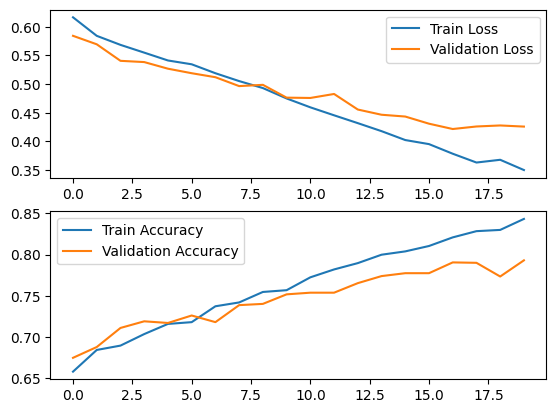

In [90]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

Evaluate Model

In [91]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7884 - loss: 0.4382
Test loss: 0.4257056713104248
Test accuracy: 0.7930513620376587


<h1> Plot Weights </h1>

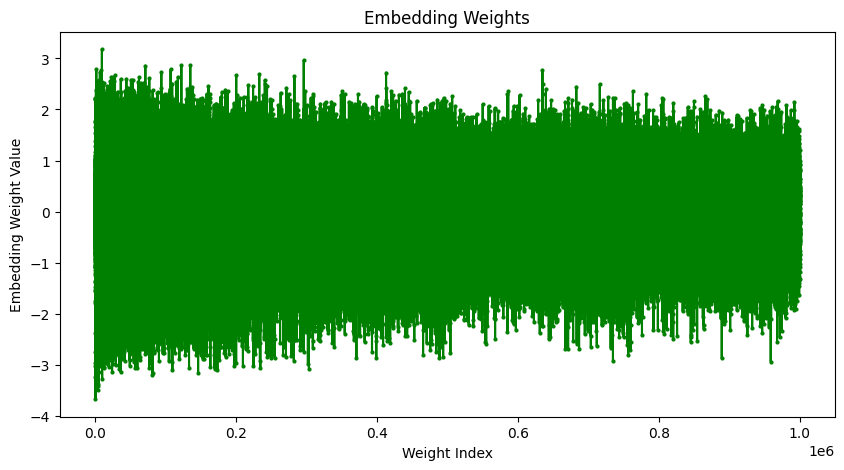

In [92]:
embedding_weights = model.layers[0].get_weights()[0]  # Extracting embedding weights
embedding_weights_flat = embedding_weights.flatten()

# Create an index for the weights
embedding_index = np.arange(len(embedding_weights_flat))

# Plot the embedding weights
plt.figure(figsize=(10, 5))
plt.plot(embedding_index, embedding_weights_flat, marker='o', markersize=2, color='green')
plt.title('Embedding Weights')
plt.xlabel('Weight Index')
plt.ylabel('Embedding Weight Value')
plt.show()


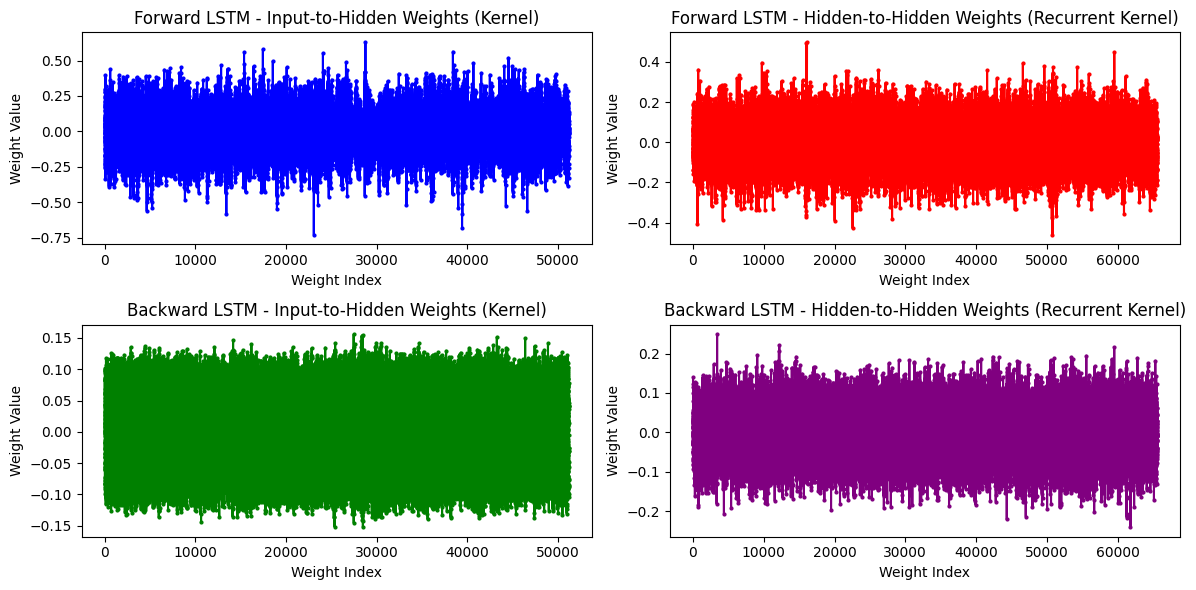

In [93]:
# Extract the Bidirectional LSTM layer
bilstm_layer = model.layers[1]  # Bidirectional LSTM is at index 2

# Get forward and backward LSTM layers
forward_lstm = bilstm_layer.forward_layer
backward_lstm = bilstm_layer.backward_layer

# Extract weights
kernel_f, recurrent_kernel_f, bias_f = forward_lstm.get_weights()  # Forward LSTM
kernel_b, recurrent_kernel_b, bias_b = backward_lstm.get_weights()  # Backward LSTM

# Flatten weights
kernel_f_flat = kernel_f.flatten()
recurrent_f_flat = recurrent_kernel_f.flatten()
kernel_b_flat = kernel_b.flatten()
recurrent_b_flat = recurrent_kernel_b.flatten()  # Added missing recurrent weights for backward LSTM

# Create weight indices
kernel_f_index = np.arange(len(kernel_f_flat))
recurrent_f_index = np.arange(len(recurrent_f_flat))
kernel_b_index = np.arange(len(kernel_b_flat))
recurrent_b_index = np.arange(len(recurrent_b_flat))  # Fixed missing index

# Plot Forward LSTM weights
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(kernel_f_index, kernel_f_flat, marker='o', linestyle='-', markersize=2, color='blue')
plt.title('Forward LSTM - Input-to-Hidden Weights (Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2, 2, 2)
plt.plot(recurrent_f_index, recurrent_f_flat, marker='o', linestyle='-', markersize=2, color='red')
plt.title('Forward LSTM - Hidden-to-Hidden Weights (Recurrent Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

# Plot Backward LSTM weights
plt.subplot(2, 2, 3)
plt.plot(kernel_b_index, kernel_b_flat, marker='o', linestyle='-', markersize=2, color='green')
plt.title('Backward LSTM - Input-to-Hidden Weights (Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.subplot(2, 2, 4)
plt.plot(recurrent_b_index, recurrent_b_flat, marker='o', linestyle='-', markersize=2, color='purple')  # Fixed missing plot
plt.title('Backward LSTM - Hidden-to-Hidden Weights (Recurrent Kernel)')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.tight_layout()
plt.show()


<h1> Prediction </h1>

In [26]:
mymodel = load_model("mymodel.h5")
text = ["Japan's Sony more than doubles net loss forecast to $6.4 billion", "The Entire Country of Sri Lanka is About to Get Balloon-Based Internet, Thanks to Google", "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ", "In accordance with our strategy , we strengthened our local presence by establishing a representative office in South Africa in October ."]
label = np.array([0, 1, 0, 1], dtype=np.int32)
tokenized_text = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=input_length, padding="pre")
predict = mymodel.predict(tokenized_text)
predict = np.array([0 if i < 0.5 else 1 for i in predict], dtype=np.int32)
print(label, predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
[0 1 0 1] [1 0 0 1]


<h1> Save the model </h1>

model.save("mymodel.h5")
model.save_weights("mymodel.weights.h5")